<a href="https://colab.research.google.com/github/makezazainw/FinalProject/blob/master/Show%20Lab-Original%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Upload file if you want**

In [ ]:
from google.colab import files
pbfile = files.upload()

**Install Kaggle**

In [1]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 2.4MB/s 
     |████████████████████████████████| 5.3MB 6.0MB/s 
     |████████████████████████████████| 143kB 29.2MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 112kB 33.5MB/s 


**Call file from Json for use Kaggle Dataset**



In [2]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "thammatattantipitham" 
os.environ['KAGGLE_KEY'] = "3cf826ab97707228fb1602519992740b"

In [3]:
!kaggle datasets download -d thammatattantipitham/originalthaiherb --unzip

 74% 11.0M/15.0M [00:01<00:00, 9.78MB/s]
100% 15.0M/15.0M [00:01<00:00, 9.40MB/s]


**Move to Directory thai-herb**

In [4]:
!mkdir originalthaiherb
!mv  "train" "val" originalthaiherb

**Start**

In [1]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import keras

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.applications import InceptionV3
sys.version

'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

In [2]:
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [3]:
DATASET_PATH  = 'originalthaiherb/'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 10
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
epochs    = 200

In [4]:
#ทำ aug มาเเล้ว
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
#set training data
train_generator = train_datagen.flow_from_directory(DATASET_PATH+ r"train/",
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle = True,
                                                    subset='training')

Found 1600 images belonging to 10 classes.


In [6]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(DATASET_PATH+ r"val/",                                      
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = 1,
                                                    class_mode='categorical',
                                                    shuffle = True
                                                    )

Found 410 images belonging to 10 classes.


**How to use the checkpoint from google drive**

In [ ]:
!mkdir training_1
!unzip "/content/drive/My Drive/Final Project/Dataset-Lab/Original/training/training.zip" "/content/training_1"

In [7]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=50)

#Create the model
base_model_resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
#Defining and Adding layers
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'),input_dim=64))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(NUM_CLASSES,activation=('softmax'))) #This is the classification layer


# Save the weights using the `checkpoint_path` format
model_resnet.save_weights(checkpoint_path.format(epoch=0))

In [8]:
train_generator.class_indices

{'eilerd': 0,
 'fahthalinejol': 1,
 'horapa': 2,
 'krapao': 3,
 'lemon': 4,
 'magrud': 5,
 'plu': 6,
 'sabtiger': 7,
 'saranae': 8,
 'yanang': 9}

In [9]:
#Model summary
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [10]:
model_resnet.compile(optimizer=Adam(lr=0.0001),  #Adam(lr=1e-5)
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
#start to train the model
start = time.time()
history = model_resnet.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.samples//BATCH_SIZE, validation_data=valid_generator,validation_steps=valid_generator.samples,callbacks=[cp_callback],verbose=1)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
50/50 [==============================] - 49s 990ms/step - loss: 1.6327 - accuracy: 0.5213 - val_loss: 1.0827 - val_accuracy: 0.7049
Epoch 2/200
50/50 [==============================] - 49s 970ms/step - loss: 0.2686 - accuracy: 0.9131 - val_loss: 0.4554 - val_accuracy: 0.8829
Epoch 3/200
50/50 [==============================] - 48s 966ms/step - loss: 0.1466 - accuracy: 0.9631 - val_loss: 0.6906 - val_accuracy: 0.8488
Epoch 4/200
50/50 [==============================] - 49s 971ms/step - loss: 0.0984 - accuracy: 0.9750 - val_loss: 0.4160 - val_accuracy: 0.9244
Epoch 5/200
50/50 [==============================] - 49s 971ms/step - loss: 0.1034 - accuracy: 0.9731 - val_loss: 0.0206 - val_accuracy: 0.9976
Epoch 6/200
50/50 [==============================] - 48s 967ms/step - loss: 0.0375 - accuracy: 0.9906 - val_loss: 0.0073 - val_accuracy: 0.9976
Epoch 7/200
50/50 [==============================] - 48s 968

KeyboardInterrupt: ignored

**Make Zipfile to training for saving in google drive**

In [32]:
!zip -r "/content/drive/My Drive/Final Project/Dataset-Lab/Original/training/training.zip" "training_2"

  adding: training_2/ (stored 0%)
  adding: training_2/cp-0002.ckpt.index (deflated 82%)
  adding: training_2/cp-0004.ckpt.index (deflated 82%)
  adding: training_2/cp-0050.ckpt.data-00000-of-00001 (deflated 12%)
  adding: training_2/cp-0100.ckpt.index (deflated 82%)
  adding: training_2/cp-0000.ckpt.data-00000-of-00001 (deflated 9%)
  adding: training_2/cp-0004.ckpt.data-00000-of-00001 (deflated 23%)
  adding: training_2/cp-0100.ckpt.data-00000-of-00001 (deflated 12%)
  adding: training_2/cp-0000.ckpt.index (deflated 82%)
  adding: training_2/cp-0150.ckpt.data-00000-of-00001 (deflated 13%)
  adding: training_2/checkpoint (deflated 40%)
  adding: training_2/cp-0050.ckpt.index (deflated 82%)
  adding: training_2/cp-0150.ckpt.index (deflated 82%)
  adding: training_2/cp-0002.ckpt.data-00000-of-00001 (deflated 23%)


**Save model file .h5**

In [23]:
!mkdir save_model
model_resnet.save('save_model/model-resnet50(200epochs).h5') #ดูจำนวนรอบที่เทรนด้วยว่าทั้งหมดกี่รอบจริงๆเเล้ว

**Save file json**

In [ ]:
#Import dependencies
!mkdir jsonfile
import json
from keras.models import model_from_json, load_model
with open('jsonfile/model_resnet.json', 'w') as f:
    f.write(model.to_json())
print("Saved model to disk")

**Show graphs**

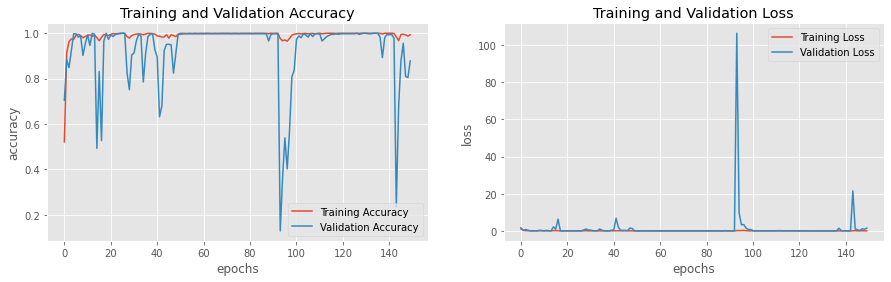

In [12]:
#กราฟเเม่นยำเเละ loss
import matplotlib.pyplot as plt

acc = model_resnet.history.history['accuracy']
val_acc = model_resnet.history.history['val_accuracy']

loss= model_resnet.history.history['loss']
val_loss= model_resnet.history.history['val_loss']


plt.style.use("ggplot")
#  "Accuracy"
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#  "Loss"
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()
# plt.savefig('accandloss.png')

**Check the checkpoints of model**

In [14]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0150.ckpt'

In [19]:
# Load the previously saved weights
model_resnet.load_weights(latest)

# Re-evaluate the model
loss, acc = model_resnet.evaluate(x,y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

410/410 - 11s - loss: 1.4551 - accuracy: 0.8780
Restored model, accuracy: 87.80%


In [18]:
#สำหรับเช็คค่าของการเทส
x,y = valid_generator.next()
x.shape
y.shape

(1, 10)

**Save the model**

In [35]:
# Save the entire model as a SavedModel.
model_resnet.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [36]:
!ls saved_model/my_model

assets	saved_model.pb	variables


**Convert file model .pb to tflite**

In [37]:
model= tf.keras.models.load_model('saved_model/my_model')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("tf_lite_model.tflite", "wb").write(tflite_model) 

INFO:tensorflow:Assets written to: /tmp/tmpwzetbf5g/assets


507786404

In [38]:
!mv "tf_lite_model.tflite" "/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model/tflite"
print("Success")

Success


**Prediction**

In [20]:
categories =  ['eilerd', 'fahthalinejol', 'horapa', 'krapao', 'lemon', 'magrud', 'plu', 'sabtiger', 'saranae', 'yanang']

In [24]:
model = model_resnet.load_weights('save_model/model-resnet50(200epochs).h5')

In [ ]:
loss, acc = model.evaluate(valid_generator, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

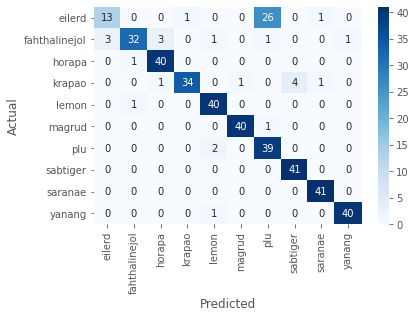

test accuracy : 87.8048780487805


In [27]:
import seaborn as sn
import pandas as pd

model = tf.keras.models.load_model('save_model/model-resnet50(200epochs).h5')
filenames = valid_generator.filenames
nb_samples = len(valid_generator)
y_prob=[]
y_act=[]
valid_generator.reset()
for _ in range(nb_samples):
    x_test, y_test = valid_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot= True, fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

**เพิ่มเติมโอนย้ายไฟล์หลังจากเสร็จเเล้ว**

In [34]:
!mv "save_model/model-resnet50(200epochs).h5" "/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model"